In [1]:
import h5py
from matplotlib import pyplot as plt

In [2]:
base = '../../'

with h5py.File(f'{base}sdss_galaxy_spec.hdf5', 'r') as fp :

    print(list(fp['raw'].keys()))
    # redshift
    z = fp['raw']['z'][...]

    # physical properties
    age = fp['raw']['age'][...]
    metallicity = fp['raw']['metallicity'][...]
    smass = fp['raw']['smass'][...]

    # spectra, including error bars
    wavelength = fp['raw']['wavelength'][...]
    specs = fp['raw']['spec'][...]
    specerrs = fp['raw']['specerr'][...]

['age', 'dec', 'fiberid', 'metallicity', 'mjd', 'plateid', 'ra', 'smass', 'spec', 'specerr', 'wavelength', 'z', 'zerr']


In [3]:
import numpy as np
def band(spectrum, wavelength, errs):
    a = np.average(spectrum[(wavelength>4000)&(wavelength<5000)], weights = 1/errs[(wavelength>4000)&(wavelength<5000)])
    b = np.average(spectrum[(wavelength>5000)&(wavelength<6000)], weights = 1/errs[(wavelength>5000)&(wavelength<6000)])
    c = np.average(spectrum[(wavelength>6000)&(wavelength<7000)], weights = 1/errs[(wavelength>6000)&(wavelength<7000)])
    d = np.average(spectrum[(wavelength>7000)&(wavelength<8000)], weights = 1/errs[(wavelength>7000)&(wavelength<8000)])
    e = np.average(spectrum[(wavelength>8000)&(wavelength<9000)], weights = 1/errs[(wavelength>8000)&(wavelength<9000)])
    f = np.average(spectrum[(wavelength>9000)&(wavelength<10000)], weights = 1/errs[(wavelength>9000)&(wavelength<10000)])
    return [a, b, c, d, e, f]

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import copy

clean = (metallicity>0)&(smass>0)&(age>0)&(z>0)
property = np.vstack([metallicity[clean], np.log10(smass[clean]), np.log10(age[clean]), z[clean]]).T
scaler = StandardScaler()
property_norm = scaler.fit_transform(property)

photometry = []
for i in np.arange(len(clean))[clean]:
    photometry.append(band(specs[i], wavelength, specerrs[i]))
photometry = np.array(photometry)
index = np.arange(np.sum(clean))

train_X, temp_X, train_Y, temp_Y, train_index, temp_index= train_test_split(property_norm, np.log10(photometry), index,  test_size=0.2)
val_X, test_X, val_Y, test_Y, val_index, test_index= train_test_split(temp_X, temp_Y, temp_index, test_size=0.5)

dtype = torch.float
train_X = torch.from_numpy(train_X).type(dtype)
test_X = torch.from_numpy(test_X).type(dtype)
val_X = torch.from_numpy(val_X).type(dtype)

train_Y = torch.from_numpy(train_Y).type(dtype)
test_Y = torch.from_numpy(test_Y).type(dtype)
val_Y = torch.from_numpy(val_Y).type(dtype)

dataset = TensorDataset(train_X, train_Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(4, 64, bias=True),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64, bias=True),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64, bias=True),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 6, bias=True)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

patience = 20
best_loss = float("inf")
trigger_times = 0
best_model = copy.deepcopy(model)

# DataLoader（val/testも用意）
val_dataset  = TensorDataset(val_X, val_Y)
test_dataset = TensorDataset(test_X, test_Y)

train_loader = loader  # 既に作成済み
val_loader   = DataLoader(val_dataset,  batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 損失関数と最適化
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

max_epochs = 1000  # 上限（早期終了で止まる想定）

for epoch in range(1, max_epochs + 1):
    # ---- train ----
    model.train()
    train_loss = 0.0
    n_train = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_loss += loss.item() * bs
        n_train += bs

    train_loss /= max(n_train, 1)

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    n_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            bs = xb.size(0)
            val_loss += loss.item() * bs
            n_val += bs
    val_loss /= max(n_val, 1)

    print(f"Epoch {epoch:4d} | train {train_loss:.6f} | val {val_loss:.6f}")

    # ---- early stopping ----
    if val_loss + 1e-9 < best_loss:   # わずかな数値誤差を許容
        best_loss = val_loss
        trigger_times = 0
        best_model = copy.deepcopy(model)
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch} (no val improvement in {patience} epochs).")
            break

# ---- best model でテスト評価 ----
model = best_model.to(device)
model.eval()
test_loss = 0.0
n_test = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        bs = xb.size(0)
        test_loss += loss.item() * bs
        n_test += bs
test_loss /= max(n_test, 1)
print(f"[TEST] MSE: {test_loss:.6f}")



Epoch    1 | train 0.391441 | val 0.353370
Epoch    2 | train 0.323951 | val 0.297297
Epoch    3 | train 0.268849 | val 0.246488
Epoch    4 | train 0.225705 | val 0.211240
Epoch    5 | train 0.192055 | val 0.181075
Epoch    6 | train 0.165267 | val 0.155612
Epoch    7 | train 0.141588 | val 0.131156
Epoch    8 | train 0.124184 | val 0.115442
Epoch    9 | train 0.108069 | val 0.098148
Epoch   10 | train 0.094913 | val 0.088270
Epoch   11 | train 0.083282 | val 0.082472
Epoch   12 | train 0.075018 | val 0.071113
Epoch   13 | train 0.067650 | val 0.062455
Epoch   14 | train 0.060673 | val 0.057257
Epoch   15 | train 0.055173 | val 0.054589
Epoch   16 | train 0.050944 | val 0.051281
Epoch   17 | train 0.046767 | val 0.042791
Epoch   18 | train 0.043252 | val 0.041227
Epoch   19 | train 0.041618 | val 0.039725
Epoch   20 | train 0.038384 | val 0.035655
Epoch   21 | train 0.037351 | val 0.035526
Epoch   22 | train 0.035050 | val 0.032502
Epoch   23 | train 0.033857 | val 0.031752
Epoch   24 

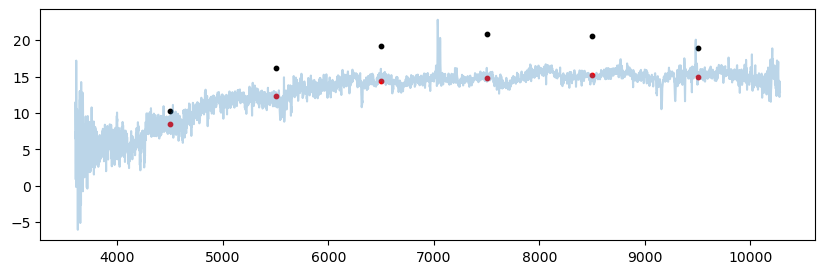

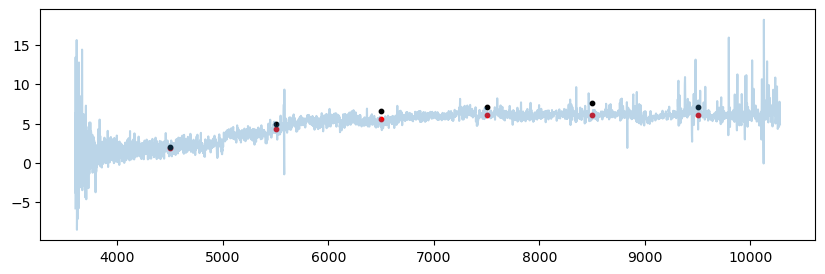

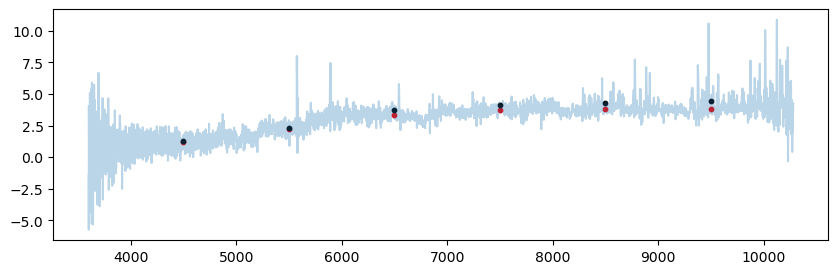

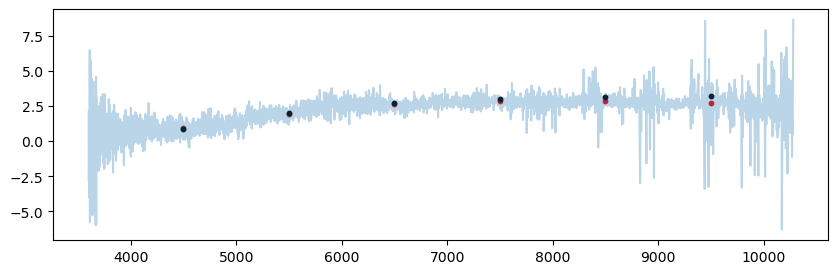

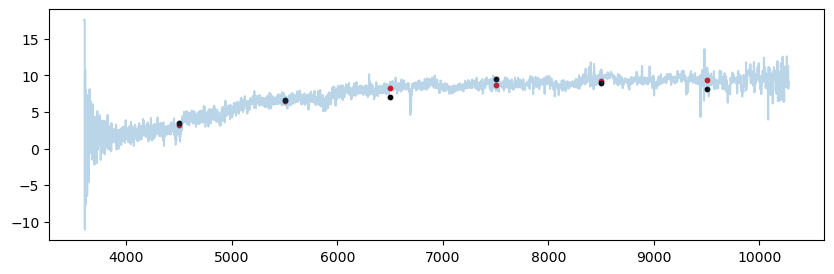

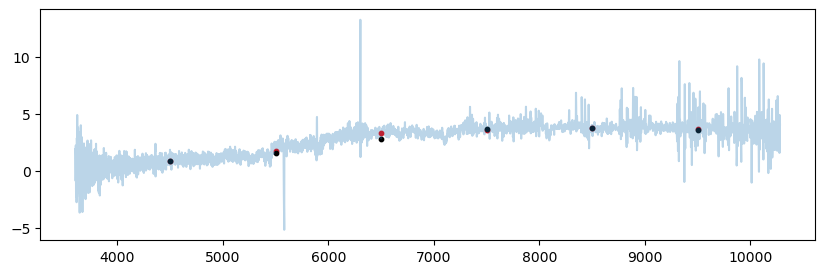

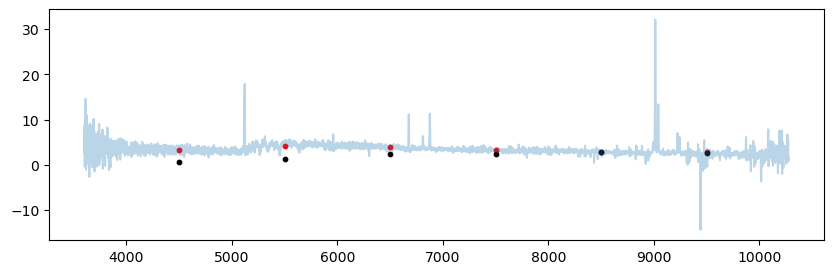

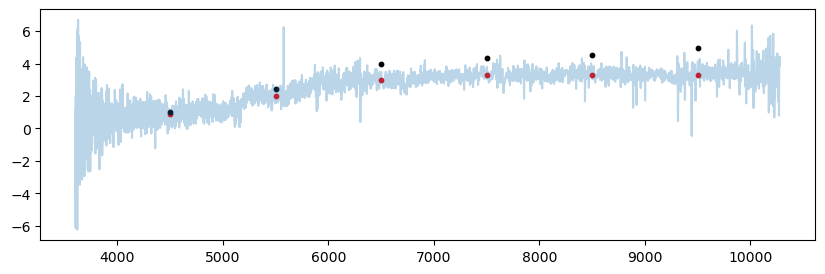

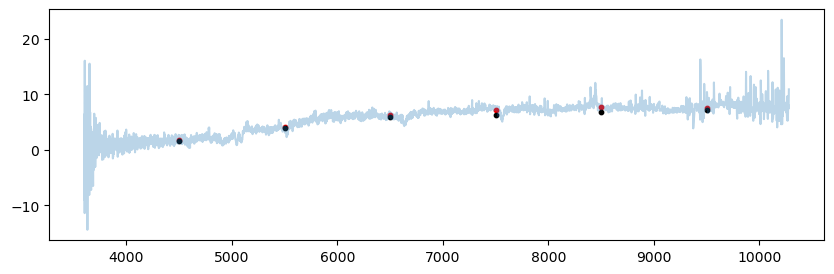

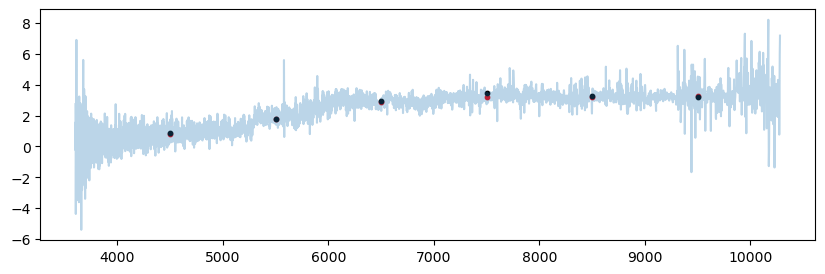

In [20]:
for i in range(10):
    test = test_X[i]
    true = test_Y[i]
    true = 10**true
    spec = specs[clean][test_index[i]]
    pred = model(test.reshape(-1, 1).T).detach().numpy()
    pred = 10**pred
    #plt.figure(figsize=(5,5))
    #plt.scatter(pred.detach().numpy(), true)
    fig = plt.figure(figsize=(10, 3))
    plt.plot(wavelength, spec, alpha = 0.3)
    plt.scatter([4500, 5500, 6500, 7500, 8500, 9500], true, color='red', s=10)
    plt.scatter([4500, 5500, 6500, 7500, 8500, 9500], pred, color='black', s=10)

(array([ 16.,  16.,  12., 109.,  54.,  97.,  58., 108.,  45.,  59.,  90.,
         40.,  42.,  53.,  28.,  66.,  26.,  22.,  19.,   9.,   3.,   6.,
          2.,   2.,   3.,   1.,   1.,   0.,   1.,   3.]),
 array([0.0149659 , 0.07658957, 0.13821325, 0.19983692, 0.2614606 ,
        0.32308429, 0.38470796, 0.44633162, 0.50795531, 0.56957901,
        0.6312027 , 0.69282633, 0.75445002, 0.81607372, 0.87769735,
        0.93932104, 1.00094473, 1.06256843, 1.12419212, 1.18581581,
        1.2474395 , 1.30906308, 1.37068677, 1.43231046, 1.49393415,
        1.55555785, 1.61718154, 1.67880523, 1.74042881, 1.8020525 ,
        1.86367619]),
 <BarContainer object of 30 artists>)

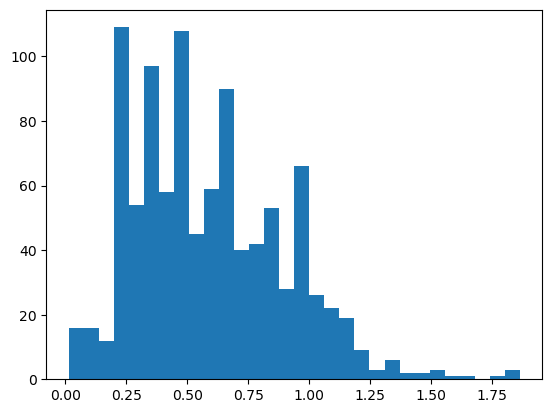

In [32]:
plt.hist(Z, bins=30)
#plt.xscale("log")

In [8]:
np.array(xb).shape

/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_9051/1381612602.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(xb).shape


(223, 4)

In [11]:
np.array(test).reshape(-1,1).shape

/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_9051/3964583151.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(test).reshape(-1,1).shape


(4, 1)